Explore transition tuning of multiplicative adaptive neuron model

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

from disp import set_plot

cc = np.concatenate

DT = .005

In [78]:
df_ma_param = pd.read_csv('data/simple/neur/baker_ma_fit_param.csv')
tau_rs = df_ma_param['TAU_R']
tau_as = df_ma_param['TAU_A']
x_ss = df_ma_param['X_S']
x_ps = df_ma_param['X_P']
df_ma_param.iloc[100:120]

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
100,100,SS35473,4,ammc,True,0.247819,True,-0.000000,-0.133463,0.925439,32.442249,1.294914,2.953664
101,101,SS35473,5,ammc,True,0.755134,True,-0.588235,-0.548592,0.915126,13.593382,-0.380249,3.178877
102,102,SS35473,0,medial projection,False,0.217074,True,-0.000000,-0.061477,1.167695,39.391724,2.164475,2.592636
103,103,SS35473,0,somas,False,0.601837,True,-0.705882,-0.311854,1.498865,48.551575,1.906945,2.165999
104,104,SS35502,0,horizontal projection,True,0.306577,True,-0.000000,0.042607,0.370899,3.675780,2.376338,7.374466
105,105,SS35502,1,horizontal projection,True,0.521015,True,-0.000000,0.154661,0.381235,3.249410,0.708106,6.999646
106,106,SS35502,2,horizontal projection,True,0.741565,True,-0.117647,-0.315300,0.521652,3.831555,0.888111,6.710620
107,107,SS35502,3,horizontal projection,True,0.389834,True,-0.000000,-0.012286,0.469434,2.701080,0.667424,8.611498
108,108,SS35502,4,horizontal projection,True,0.506480,True,-0.000000,0.011071,0.464939,2.589743,-0.081377,8.895911
109,109,SS35502,5,horizontal projection,True,0.377725,True,-0.000000,0.038850,0.619156,3.967134,0.927937,7.094790


In [79]:
def make_step(mode, dur_on=10, dur_off=10):
    t = np.arange(0, dur_on+dur_off, DT)
    i_s = np.zeros(len(t))
    i_p = np.zeros(len(t))
    
    if mode == 's':
        i_s[t < dur_on] = 1
    elif mode == 'p':
        i_p[t < dur_on] = 1
        
    return t, i_s, i_p


def make_flicker(frq, dur, duty=.5, mode_0='p', mode_1='s'):
    t = np.arange(0, dur, DT)
    mask = signal.square(2*np.pi*frq*t, duty=duty) == 1
    
    if (mode_0 == 'p'):
        i_p = mask.astype(float)
        if mode_1 == 's':
            i_s = (~mask).astype(float)
        elif mode_1 == 'q':
            i_s = np.zeros(len(mask))
    if (mode_0 == 's'):
        i_s = mask.astype(float)
        if mode_1 == 'p':
            i_p = mask.astype(float)
        elif mode_1 == 'q':
            i_p = np.zeros(len(mask))
    
    return t, i_s, i_p

    
# define smln & obj function
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

In [120]:
np.nonzero(np.array(tau_as) < 3)[0]

array([ 26,  27,  57,  61,  64,  66,  75,  78,  79,  80,  81,  82,  83,
        84,  88,  89, 107, 108, 112, 118, 123, 125, 133, 141, 142, 143,
       144, 145, 157, 170, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 191, 201, 202, 204, 205, 206, 207, 208, 209, 210])

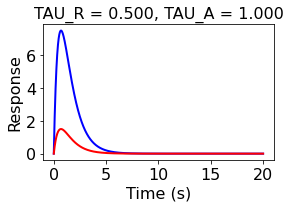

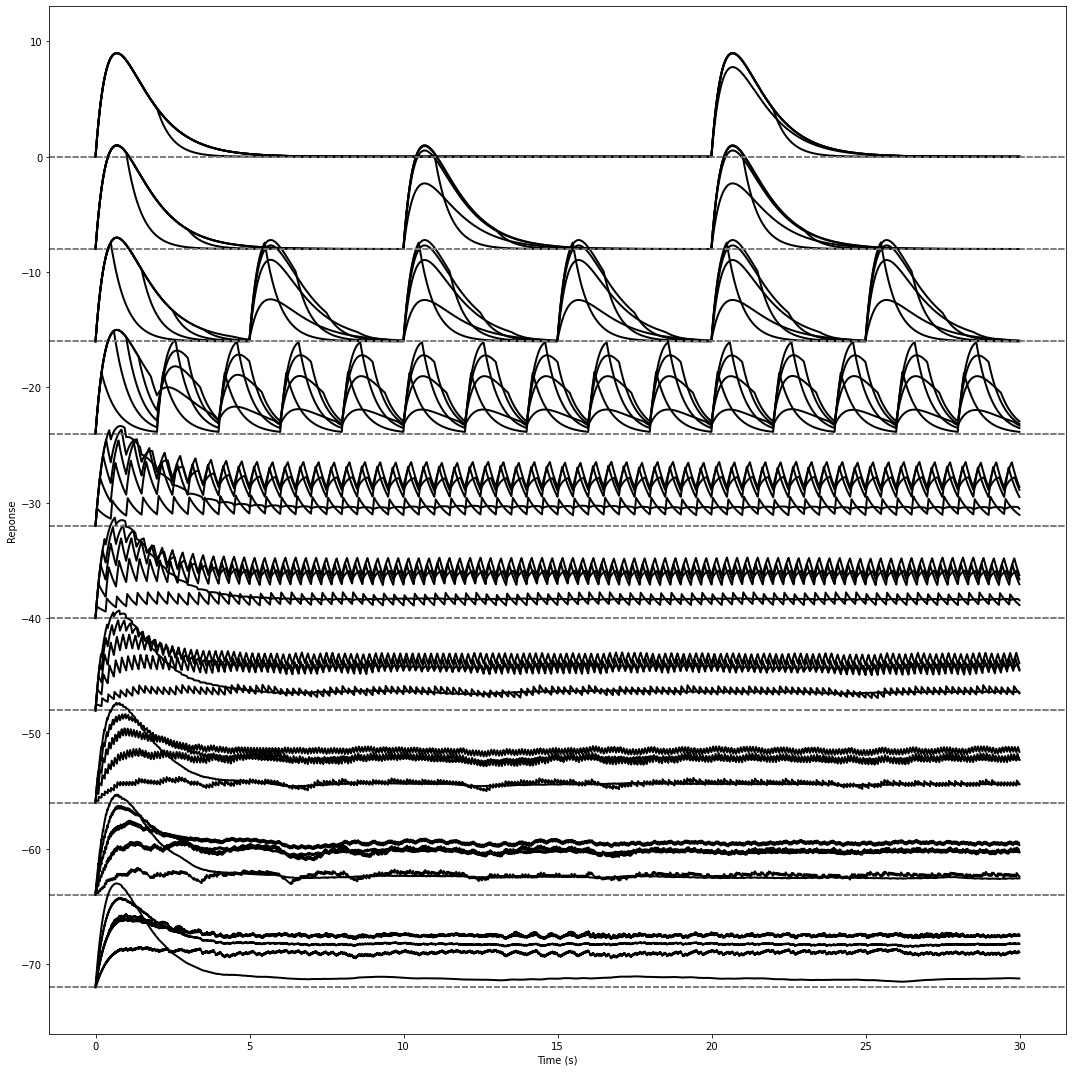

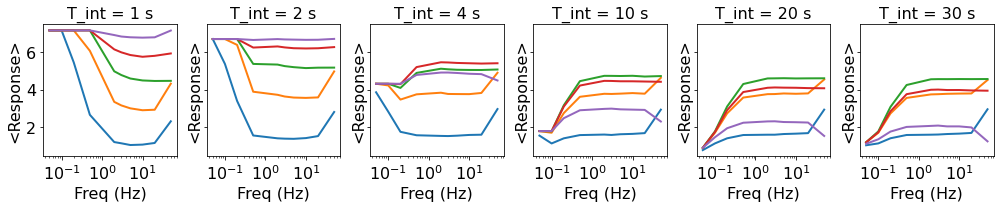

In [144]:
IXPL = 210

tau_r = tau_rs[IXPL]
tau_a = tau_as[IXPL]
x_s = x_ss[IXPL]
x_p = x_ps[IXPL]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
t, i_s, i_p = make_step(mode='s')
ax.plot(t, smlt(i_s, i_p, tau_r, tau_a, x_s, x_p), lw=2, c='b')
t, i_s, i_p = make_step(mode='p')
ax.plot(t, smlt(i_s, i_p, tau_r, tau_a, x_s, x_p), lw=2, c='r')

set_plot(ax, x_label='Time (s)', y_label='Response', title=f'TAU_R = {tau_r:.3f}, TAU_A = {tau_a:.3f}', font_size=16)

fig, ax = plt.subplots(1, 1, figsize=(15, 15), tight_layout=True)
frqs = [.05, .1, .2, .5, 2, 3, 5, 10, 20, 50]
duties = [.1, .3, .5, .7, .9]

rs = []
for cduty, duty in enumerate(duties):
    rs_ = []
    for cfrq, frq in enumerate(frqs):
        t, i_s, i_p = make_flicker(frq, dur=30, duty=duty, mode_0='s', mode_1='p')
        r = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)
        ax.plot(t, -cfrq*8 + r, c='k', lw=2)
        ax.axhline(-cfrq*8, c='gray', ls='--')

        rs_.append(r)
    rs.append(rs_)
rs = np.array(rs)
    
set_plot(ax, x_label='Time (s)', y_label='Reponse')

t_ints = [1, 2, 4, 10, 20, 30]
fig, axs = plt.subplots(1, len(t_ints), figsize=(14, 3), sharey=True, tight_layout=True)
for t_int, ax in zip(t_ints, axs):
    for rs_ in rs:
        r_mns = [r[t < t_int].mean() for r in rs_]
        ax.semilogx(frqs, r_mns, lw=2)
        
    set_plot(ax, x_label='Freq (Hz)', y_label='<Response>', title=f'T_int = {t_int} s', font_size=16)